### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
from pylab import *
%matplotlib inline

### Read the data frame from pickle file

In [2]:
import pickle
Stats=pickle.load(open('Weather/STAT.pickle','r'))

IOError: [Errno 2] No such file or directory: 'Weather/STAT.pickle'

This file contains a tuple of two lists:

The first list contains a dictionary of the following data for each type of measurement  

* ('SortedVals' --'Sample of values),
* ('UnDef' -- 'sample of number of undefs per row'),
* ('mean', 'mean value', ()),
* ('std', 'std', ()),
* ('low100', 'bottom 1%', ()),
* ('high100', 'top 1%', ()),
* ('low1000', 'bottom 0.1%', ()),
* ('high1000', 'top 0.1%', ()),
* ('E', 'Sum of values per day', (365,)),
* ('NE', 'count of values per day', (365,)),
* ('Mean', 'E/NE', (365,)),
* ('O', 'Sum of outer products', (365, 365)),
* ('NO', 'counts for outer products', (365, 365)),
* ('Cov', 'O/NO', (365, 365)),
* ('Var', 'The variance per day = diagonal of Cov', (365,)),
* ('eigval', 'PCA eigen-values', (365,)),
* ('eigvec', 'PCA eigen-vectors', (365, 365))

The second list contains description of each of the above data

### Script for plotting yearly plots

In [3]:
def YearlyPlots(T,ttl='',yl='',xl='',y=None,x=None,size=(10,7)):
    yearday=[i for i in range(1,366)]
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    plot_date(yearday,T, '-');
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    ylabel(yl)
    xlabel(xl)
    if y is not None:
        ylim(y)
    if x is not None:
        xlim(x)
    grid()
    title(ttl)

### Script for plotting number of observations collected

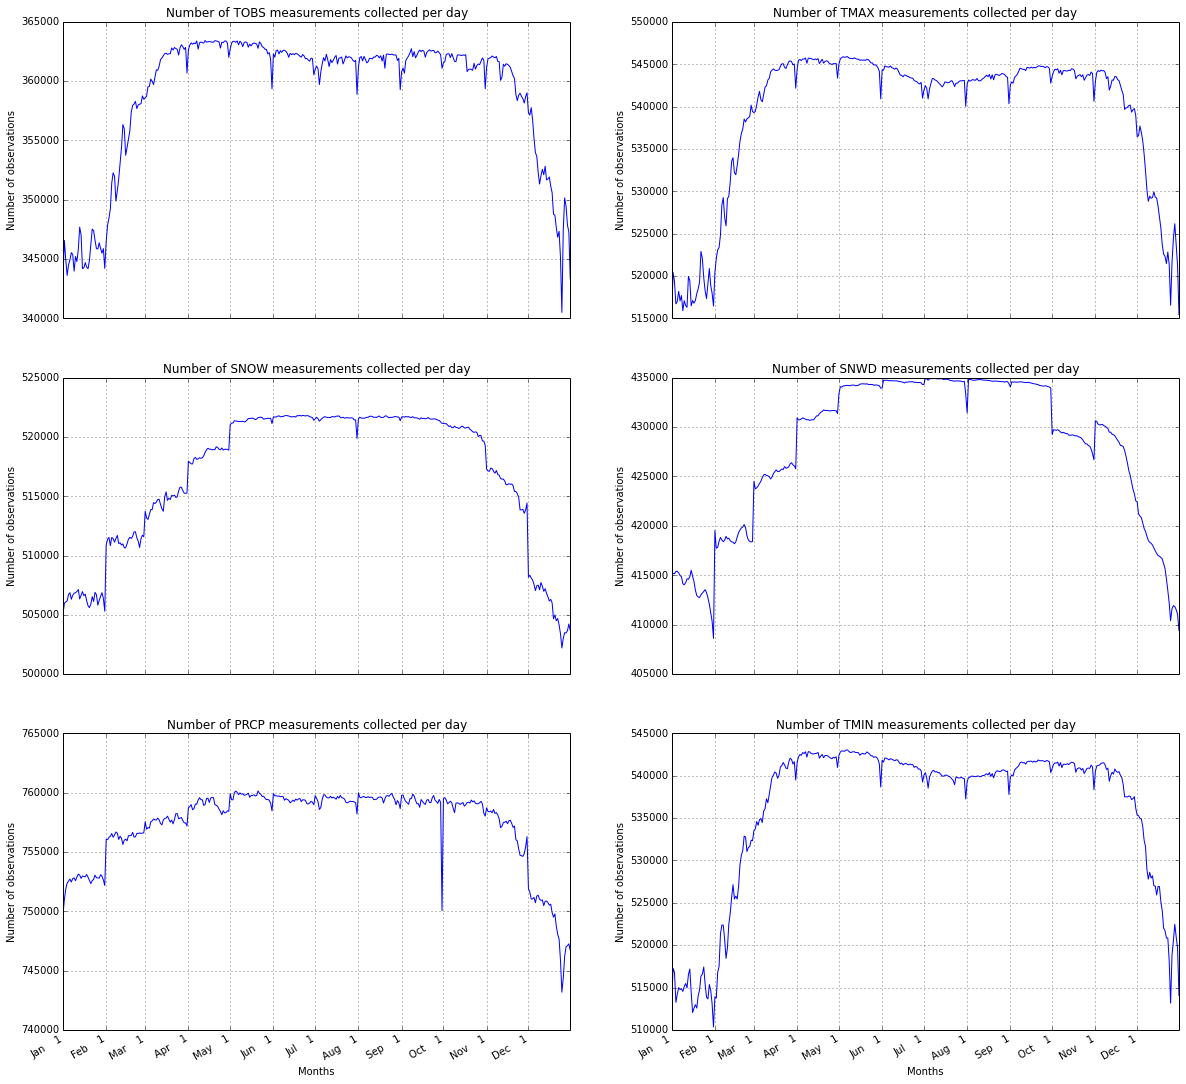

In [4]:
f=plt.figure(figsize=(20,20))
j=0
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    subplot(3,2,j)
    j+=1
    valid_m=Stats[0][m]['NE']
    YearlyPlots(valid_m, ttl='Number of ' + m + ' measurements collected per day ', xl='Months', yl='Number of observations')

### Script for plotting mean of observations

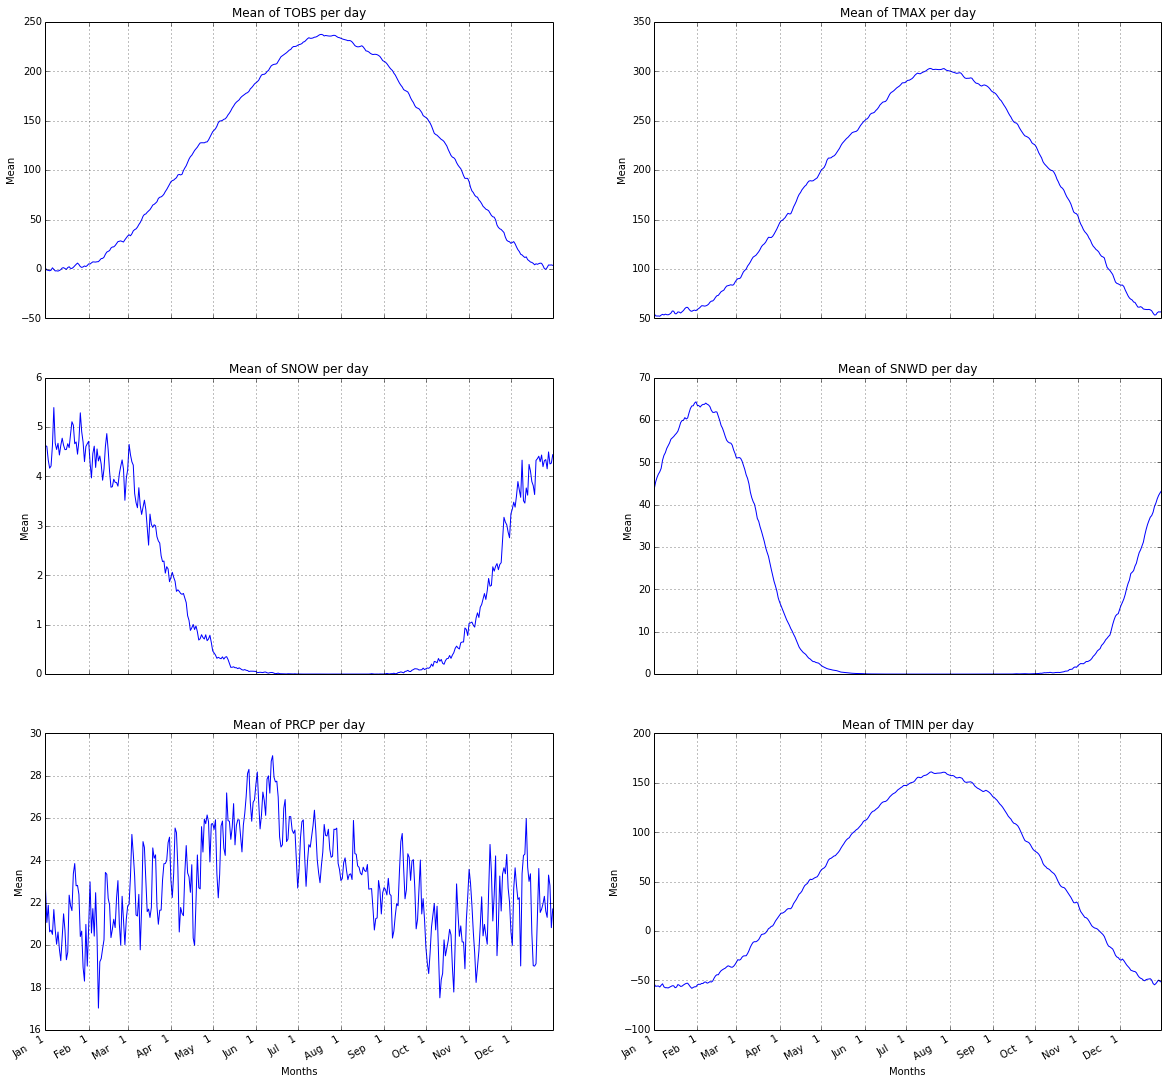

In [5]:
f=plt.figure(figsize=(20,20))
j=0
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    subplot(3,2,j)
    j+=1
    mean=Stats[0][m]['Mean']
    YearlyPlots(mean, ttl='Mean of ' + m + ' per day', xl='Months', yl='Mean')

### Script for plotting top 3 eigenvectors

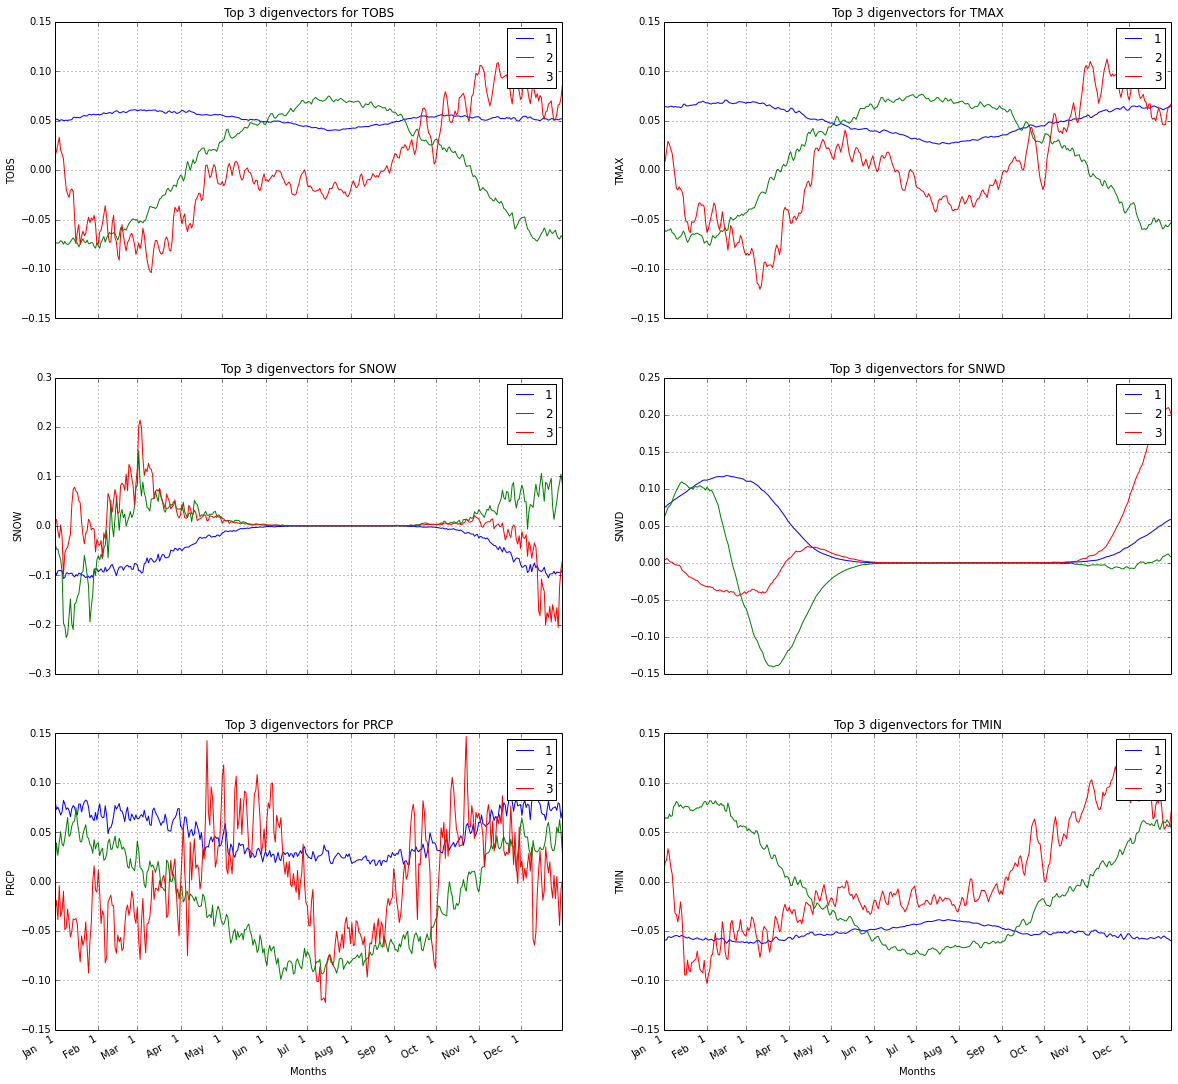

In [6]:
f=plt.figure(figsize=(20,20))
j=0
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    subplot(3,2,j)
    j+=1
    EV=Stats[0][m]['eigvec']
    YearlyPlots(EV[:,:3], ttl='Top 3 digenvectors for ' + m, xl='Months', yl=m)
    legend(range(1,4));

### Script for plotting percentage of variance explained

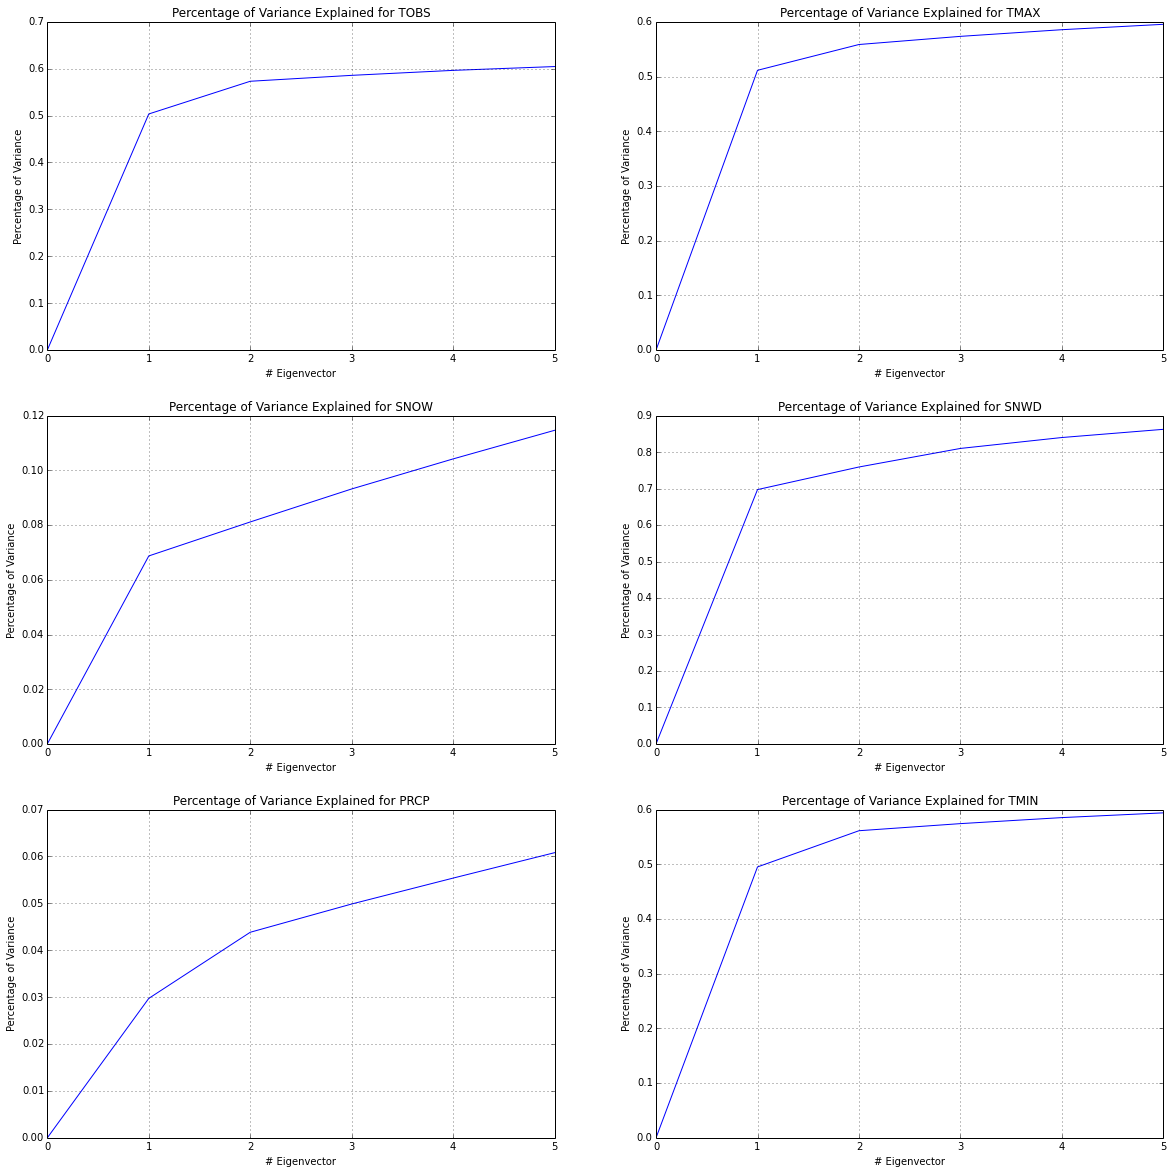

In [7]:
f=plt.figure(figsize=(20,20))
j=0
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    subplot(3,2,j)
    j+=1
    EV=Stats[0][m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

### Read and process sample data

In [8]:
Data=pickle.load(open('Weather/SampleStations.pickle','r'))

In [9]:
FlatData=[]
for station in Data:
    stationname=station[0]
    for measurements in station[1]:
        measurement,year=measurements[0]
        yeardata=list(measurements[1])
        rowData=[stationname]+[measurement]+[year]+yeardata
        FlatData.append(rowData)

In [10]:
frameheader=['station','measurement','year']+range(1,366)
df=pd.DataFrame(FlatData,columns=frameheader)

In [11]:
m_df={}
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    t_df=df[df['measurement']==m]
    if m in ['TMIN', 'TOBS', 'TMAX', 'PRCP']:
        t_df.ix[:,3:368]/=10
    m_df[m]=t_df    

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Plot Reconstructions

From each measurement, we take 4 sample stations with low residual error and 4 sample stations with high residual error and plot the following:

* Original Data Vector
* Reconstructed Data Vector from top 1 eigen vectors
* Reconstructed Data Vector from top 2 eigen vectors
* Reconstructed Data Vector from top 3 eigen vectors

In [12]:
def create_reconstructions(m):  
    Prod={}
    for k in range(1,4):
        Eigen=np.matrix(Stats[0][m]['eigvec'][:,:k])
        matrix=np.matrix(m_df[m].ix[:,2:367])-Stats[0][m]['Mean']
        matrix[isnan(matrix)]=0
        Prod[k]=matrix*Eigen
    Reconstructed={}
    for k in range(1,4):
        Eigen=np.matrix(Stats[0][m]['eigvec'][:,:k])
        Reconstructed[k]=array(Eigen*Prod[k].transpose()+Stats[0][m]['Mean'][:,np.newaxis])
        
    original=np.array(m_df[m].ix[:,2:367])-Stats[0][m]['Mean']
    residue_list=[]
    for i in range(len(Reconstructed[1][0])):
        vec_diff=original[i]-Reconstructed[3][:,i]
        residue=np.linalg.norm(vec_diff)
        residue_list.append((residue,i))
    residue_list=[x for x in residue_list if not math.isnan(x[0])]
    residue_list=sorted(residue_list)
    
    lower=[i for (r,i) in residue_list[:4]]
    upper=[i for (r,i) in residue_list[-4:]]
    
    yeardays=[i for i in (1,366)]
    plt.figure(figsize=(20,9),dpi=300)
    j=1
    c=0
    for l in lower:
        subplot(2,4,j)
        j+=1
        c+=1
        plot(original[l])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (low residual error)')
        xlim([0,365])
        legend(['original','1','2','3'],loc=2)
    
    c=0
    for l in upper:
        subplot(2,4,j)
        j+=1
        c+=1
        plot(original[l])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (high residual error)')
        xlim([0,365])
        legend(['original','1','2','3'],loc=2)


Reconstruction Plots for TMIN
Reconstruction Plots for TOBS
Reconstruction Plots for TMAX
Reconstruction Plots for SNOW
Reconstruction Plots for SNWD
Reconstruction Plots for PRCP


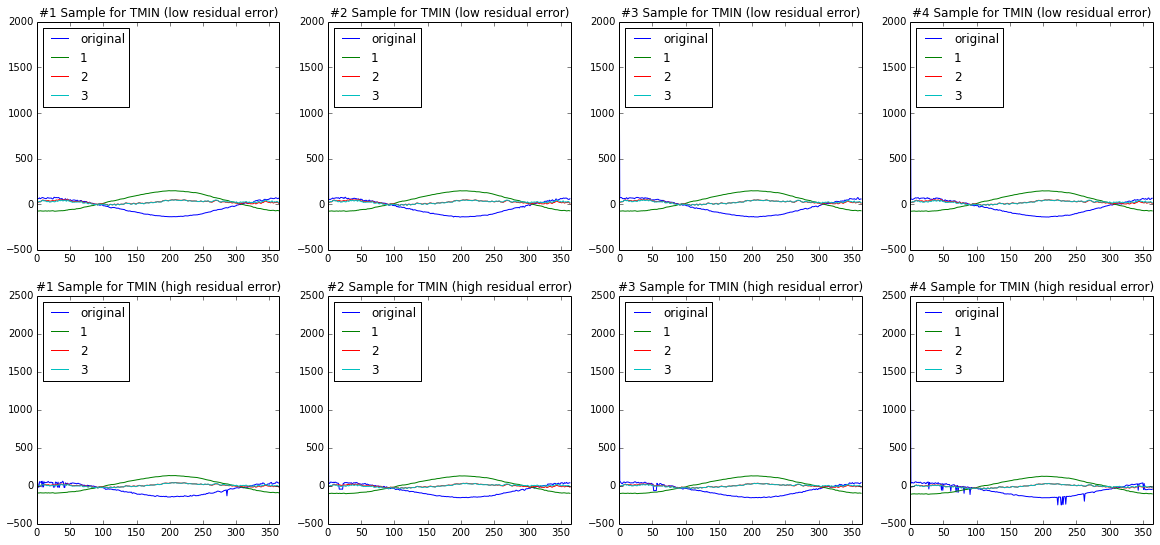

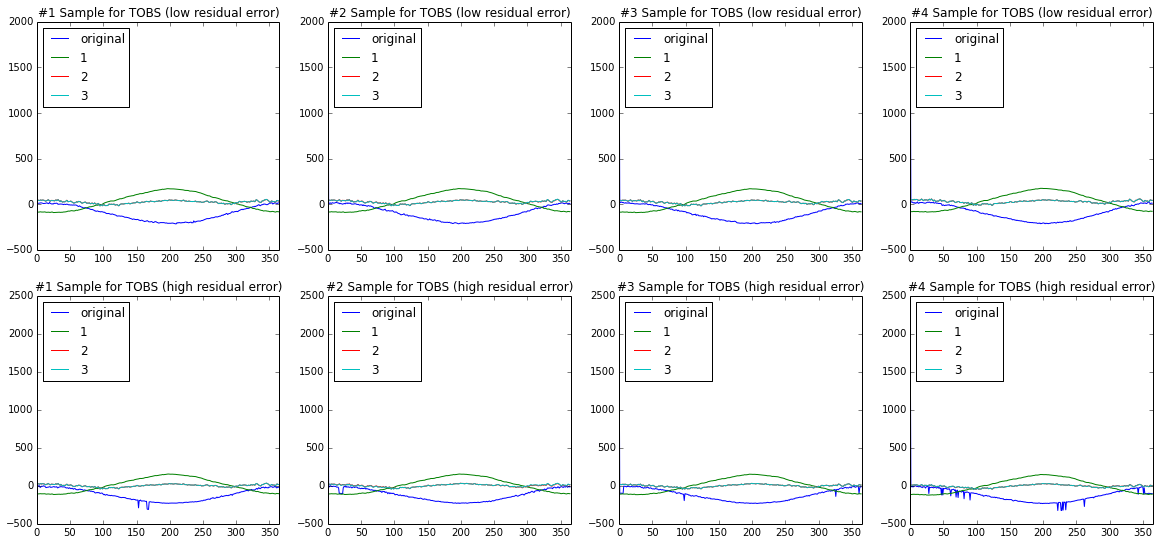

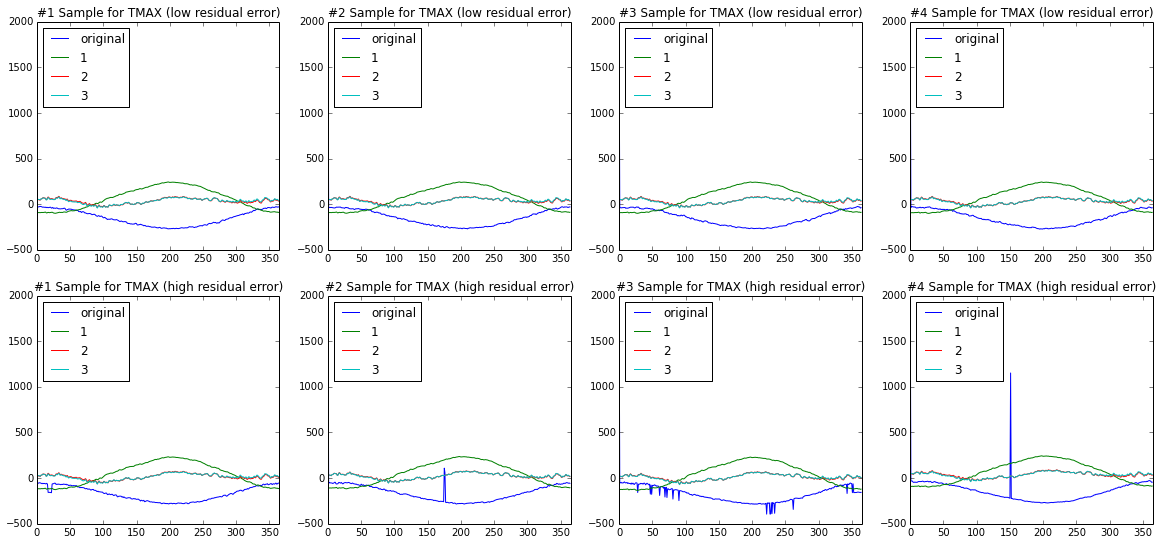

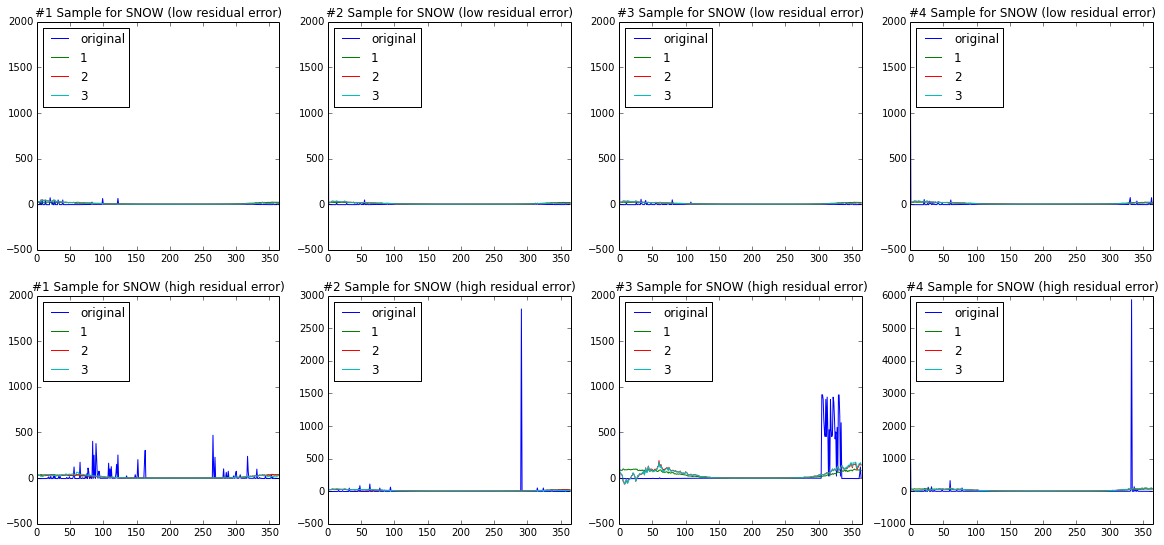

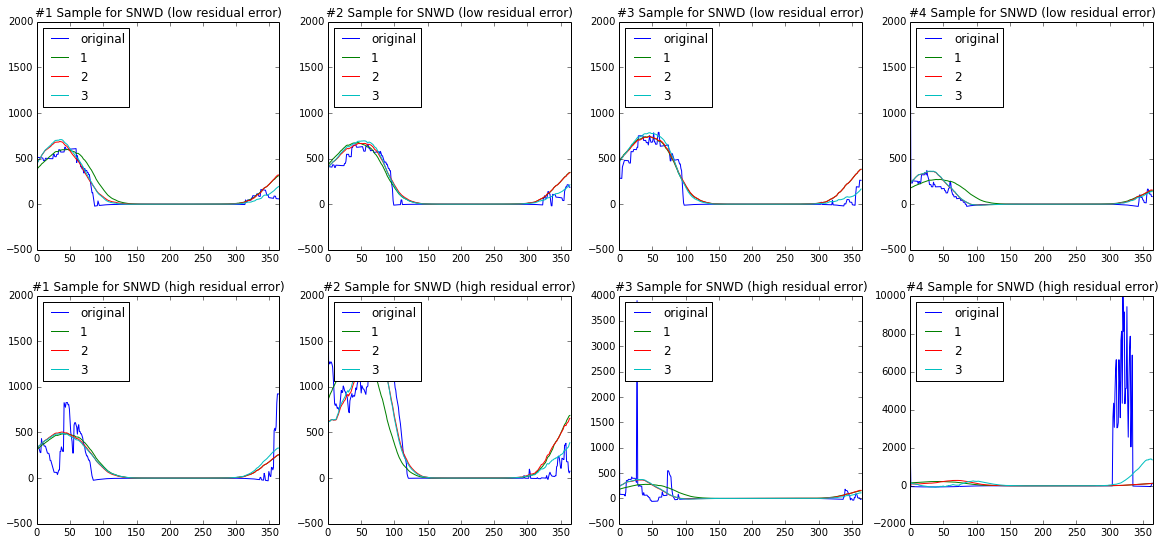

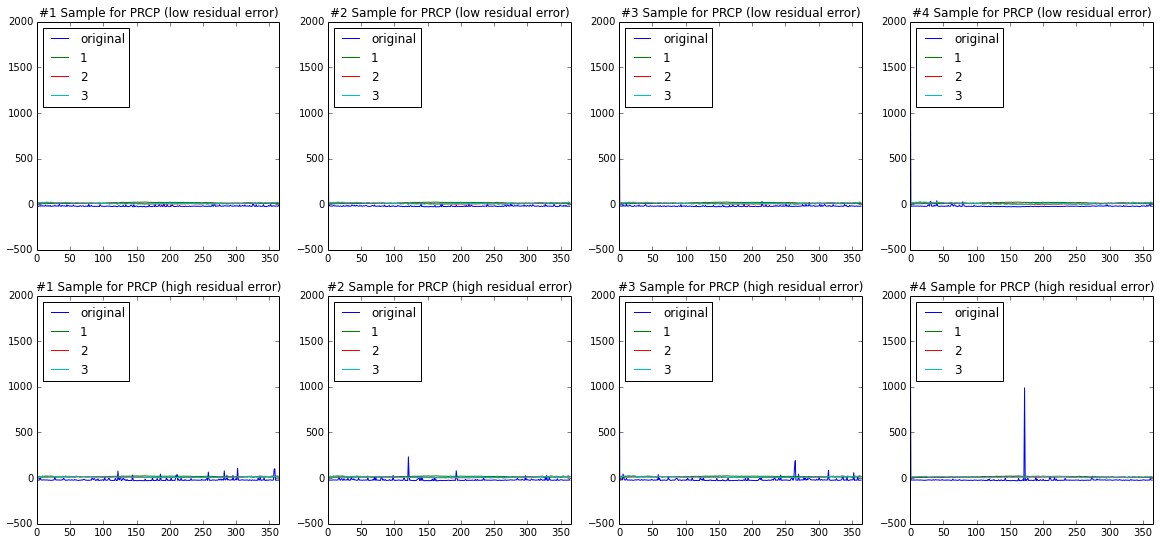

In [13]:
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)